# Cats Vs Dogs

In [1]:
import numpy as np
import pandas as pd
import glob
from os import makedirs, path
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import visualkeras
import pickle

# Clear our Tensor Graph
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

In [2]:
FAST_RUN = False
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
IMG_COL_CHANNEL = 255

constraints = {
    'FAST_RUN': FAST_RUN,
    'BATCH_SIZE': BATCH_SIZE,
    'IMG_HEIGHT': IMG_HEIGHT,
    'IMG_WIDTH': IMG_WIDTH,
    'IMAGE_SIZE': IMAGE_SIZE,
    'INPUT_SHAPE': INPUT_SHAPE,
    'IMG_COL_CHANNEL': IMG_COL_CHANNEL,
}

pickle.dump(constraints, open("./pickles/constraints.p","wb"))

In [3]:
train_dir = './data/train/'
test_dir = './data/test/'



def show_images(className): # Credit to MLMastery.com
    for i in range(9):
        # define subplot
        plt.subplot(330 + 1 + i)
        # define filename
        filename = train_dir + className + '.' + str(i) + '.jpg'
        # load image pixels
        image = plt.imread(filename)
        # plot raw pixel data
        plt.imshow(image)
        # show the figure
    return plt.show()

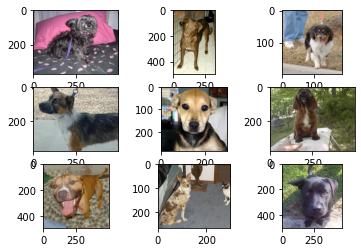

In [4]:
# Show the Dogs
show_images('dog')

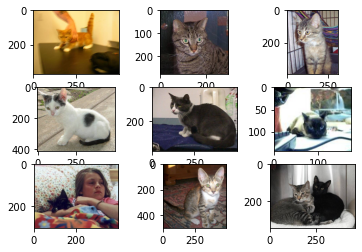

In [5]:
# Show the Cats
show_images('cat')

## 1. Building Tensors - Prepairing Files

In [6]:
# Prepairing DataFrames
def create_df(class_name, directory, label):
    path_ = f'{class_name}*.jpg'
    filepaths = pd.Series(glob.glob(path.join(directory, path_)), name='Filepath').astype(str)
    labels = pd.Series(label, name='category', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [7]:
def collect_dataFrames(class_names):
    dFrames = {}
    for class_name in  class_names:
        sub_df_name = train_dir.split('data')[1].replace('/','') + class_name
        dFrames[sub_df_name] = create_df(class_name=class_name, 
                                     directory=train_dir, 
                                     label=class_name
                                    )
    
    df= pd.concat([dFrames[i] for i in dFrames.keys()], axis=0).sample(
    frac=1.0, random_state= 42).reset_index(
    drop=True)
    
   
    
    return df

In [8]:
df = collect_dataFrames(class_names=('cat','dog'))
df.head()

,Filepath,category
0,./data/train/cat.1730.jpg,cat
1,./data/train/dog.9535.jpg,dog
2,./data/train/cat.9230.jpg,cat
3,./data/train/dog.4807.jpg,dog
4,./data/train/dog.489.jpg,dog


<AxesSubplot:>

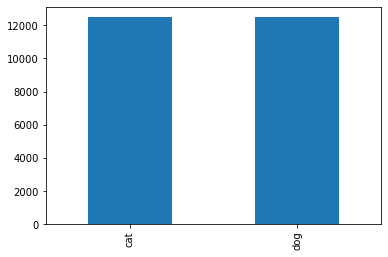

In [9]:
df['category'].value_counts().plot.bar()

In [10]:
train_df, val_df = train_test_split(
    df,
    train_size=0.80,
    random_state= 42
)







train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Pickle the frames for usage in later exeperiment notebooks/kernels
train_df.to_pickle('./pickles/train_df.pkl')
val_df.to_pickle('./pickles/val_df.pkl')


In [11]:
# Get whole shape to define fitting params for our baseline ConvNet
total_train = train_df.shape[0]
total_validate = val_df.shape[0]


### 1.1 DataGenerators

No augmentation for now this is our baseline approach before any adjustments

In [12]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./IMG_COL_CHANNEL,
    )

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./IMG_COL_CHANNEL,
)


### 1.2 Building our Tensors
Using Flow from dataframe

In [13]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=15,

)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=15,

)



Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## 2. Begin Modeling - Create Baseline Approach
Using a Single Conv Block create a baseline

In [14]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = build_model(input_shape=IMAGE_SIZE + (3,))

2023-03-20 16:35:49.088927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 16:35:49.108519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 16:35:49.108718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 16:35:49.109821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 16:35:49.109967: I tensorflow/compiler/xla/stream_executo

### 2.1 Visualize Model Architecture

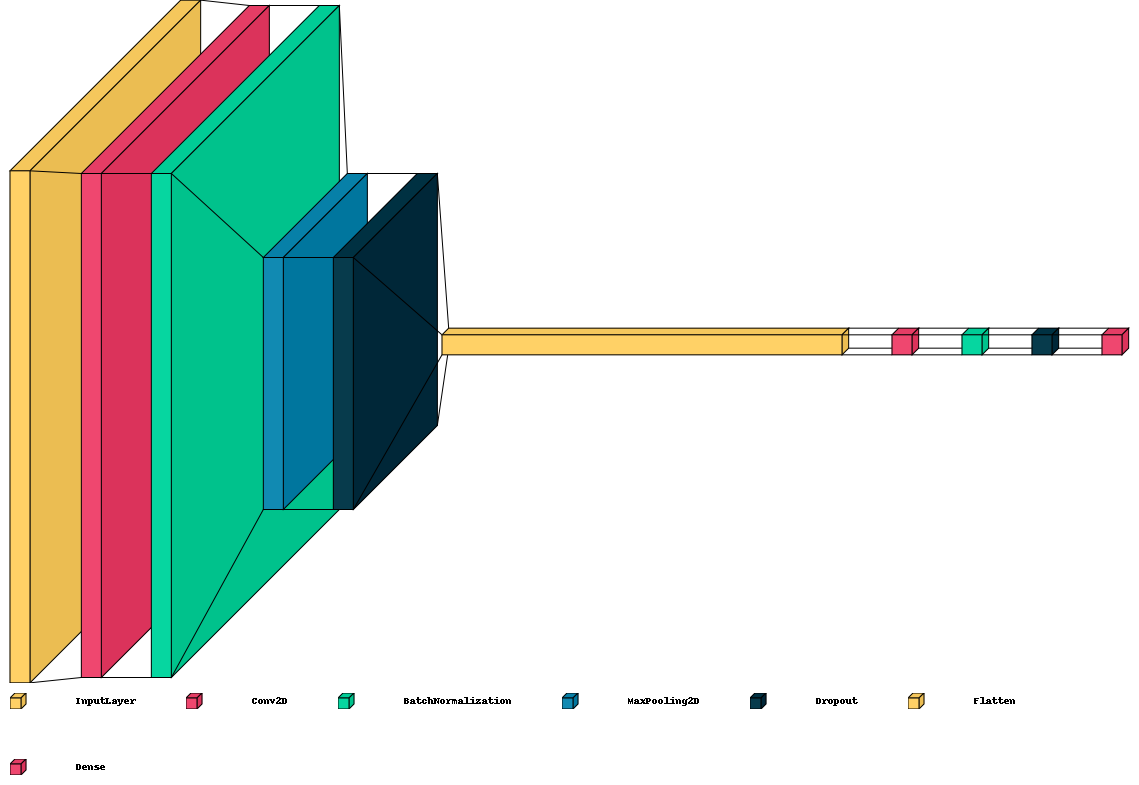

In [15]:
visualkeras.layered_view(model, legend=True, spacing=50, )

### 3.2 Compile The Model and Define Callbacks

In [16]:
# If no improvement in 10 epochs stop
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)


# Learning Rate Modulation
lr_mod = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                              paitence=2,
                                              verbose=1,
                                              factor=0.5,
                                              min_lr=0.00001)


# Set Call Backs
callbacks = [early_stop, lr_mod]

In [17]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.005), 
             loss='categorical_crossentropy', 
             metrics=['accuracy']
            )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0     

### 2.3 Begin Training

In [18]:
epochs = 5 if FAST_RUN else 50
hist = model.fit(train_data,
                 epochs=epochs,
                validation_data=val_data,
                validation_steps=total_validate//BATCH_SIZE,
                steps_per_epoch=total_train//BATCH_SIZE,callbacks=callbacks,)

Epoch 1/50


2023-03-20 16:35:50.334357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-20 16:35:50.419076: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2d4401ce20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-20 16:35:50.419105: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2023-03-20 16:35:50.423636: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-20 16:35:51.106729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-20 16:35:51.853897: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Comp

625/625 [==============================] - 13s 16ms/step - loss: 0.7083 - accuracy: 0.5817 - val_loss: 0.7748 - val_accuracy: 0.5842 - lr: 0.0050
Epoch 2/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6272 - accuracy: 0.6517 - val_loss: 0.7991 - val_accuracy: 0.5795 - lr: 0.0050
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 0.5764 - accuracy: 0.6957 - val_loss: 0.6344 - val_accuracy: 0.6816 - lr: 0.0050
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 0.5351 - accuracy: 0.7268 - val_loss: 0.9018 - val_accuracy: 0.6252 - lr: 0.0050
Epoch 5/50
625/625 [==============================] - 9s 14ms/step - loss: 0.4988 - accuracy: 0.7593 - val_loss: 0.5586 - val_accuracy: 0.7303 - lr: 0.0050
Epoch 6/50
625/625 [==============================] - 10s 16ms/step - loss: 0.4710 - accuracy: 0.7755 - val_loss: 0.5474 - val_accuracy: 0.7329 - lr: 0.0050
Epoch 7/50
625/625 [==============================] - 10s 16ms/step - los

### 2.4 Save the Model

In [19]:
model.save_weights("./weights/baseline_model.h5")

In [20]:
tf.keras.backend.clear_session()

### 2.5 Interpret Training Results

In [21]:
def interpret_epoch_hist(history): # Credit Hamza Manssor
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))
    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))
    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

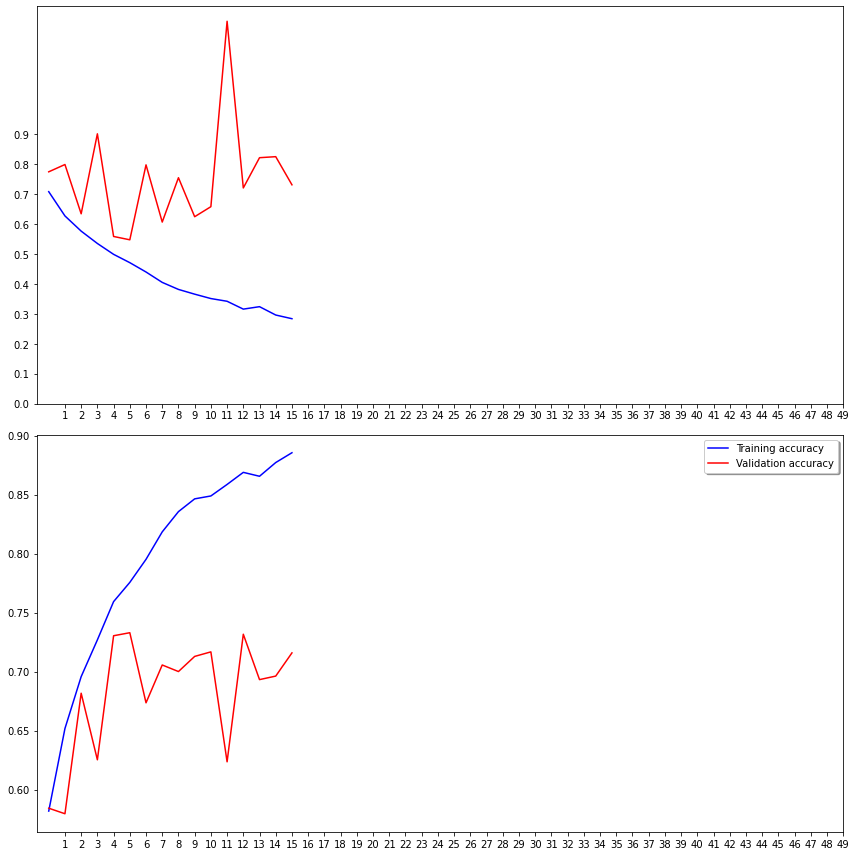

In [22]:
interpret_epoch_hist(hist)

## 3. What to do now?

So obviously we are overfitting like crazy so lets continue to 01_Adjusting_My_Approach.ipynb